# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings('ignore')


In [2]:
from pymystem3 import Mystem
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('toxic_comments.csv')    

In [4]:
display(df.head(5)), display(df.tail(5))

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


(None, None)

In [5]:
df.shape

(159292, 3)

In [6]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.toxic.value_counts() / df.toxic.count()

0    0.898388
1    0.101612
Name: toxic, dtype: float64

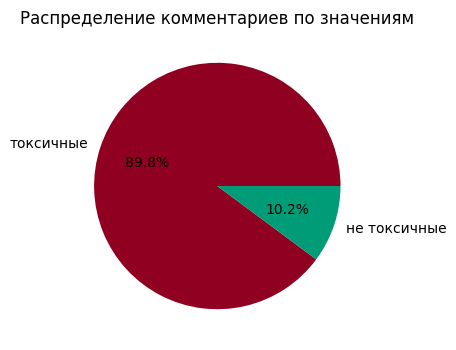

In [9]:
df.toxic.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(4, 4), title='Распределение комментариев по значениям',
                            labels=['токсичные','не токсичные'], colors = ['#900020', '#009B77'])
plt.ylabel('')
plt.show()

In [10]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [11]:
df = df.drop(['Unnamed: 0'], axis=1)

In [12]:
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Вывод:**

 - В датасете 159 292 наблюдений. Пропусков нет, явных дубликатов нет
 - Текст комментариев на английском языке, присутствуют знаки переноса строк, и иные засорения, которые нужно удалить из текстов
 - В таргете около 90% наблюдений отрицательного класса и 10% положительного
 - И мы удадили столбец Unnamed, так как он дублировал индексы

## Подготовка данных к обучению

### Приведём текст к нужному виду

Создадим корпус 

In [13]:
corpus = list(df['text'])

In [14]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Напишем функцию по очистке текста и применим к нашему тексту

In [15]:
def clear(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    text = " ".join(text.split())
    return text

In [16]:
df.text[1], df.text[2]

("D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.")

In [17]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\radim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Напишем функцию РОS-тэгирования слов которая будет использовать функцию по очистке слов и функцию по лемматизации слова

Проверим работу функции на любом тексте:

In [18]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
%%time
def lemma_function(text):
    stek = []
    for i in nltk.word_tokenize(text):
        stek.append(lemmatizer.lemmatize(i))
    return ' '.join(stek) 

lemma=[]
for i in tqdm(range(len(corpus))):
    lemma.append(lemma_function(clear(corpus[i])))

df['text']=pd.Series(lemma, index=df.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 2min 5s
Wall time: 2min 6s


In [21]:
df['text'][2]

'Hey man I m really not trying to edit war It s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info'

In [22]:
df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He match this background colour I m seem...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestion on impro...,0
4,You sir are my hero Any chance you remember wh...,0


### Разделим данные на выборки

In [23]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=42)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5, 
                                                                            random_state=42)

Проверим правильность разбивки выборок и равномерность распределения целевого признака

In [25]:
features_train.shape[0] / df.shape[0], features_valid.shape[0] / df.shape[0], features_test.shape[0] / df.shape[0], 

(0.5999987444441655, 0.19999748888833085, 0.2000037666675037)

In [26]:
target_train.shape[0] / df.shape[0], target_valid.shape[0] / df.shape[0], target_test.shape[0] / df.shape[0], 

(0.5999987444441655, 0.19999748888833085, 0.2000037666675037)

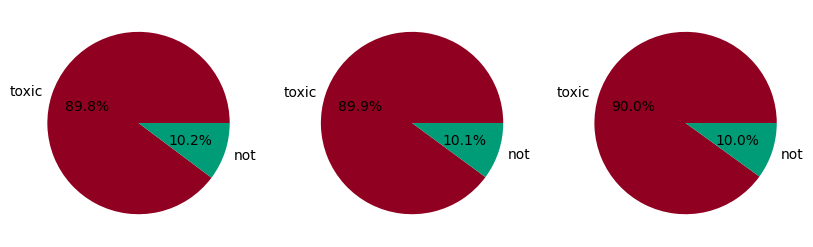

In [27]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot(131)
target_train.value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['toxic','not'], colors = ['#900020', '#009B77'])
plt.ylabel('')
plt.subplot(132)
target_valid.value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['toxic','not'], colors = ['#900020', '#009B77'])
plt.ylabel('')
plt.subplot(133)
target_test.value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['toxic','not'], colors = ['#900020', '#009B77'])
plt.ylabel('')
plt.show()

После того, как мы равномерно разделили целевой признак и проверили графически, нам теперь необходимо уравновесить дисбаланс уменьшив количество отрицательных комментариев, и увеличив количество положительных в одной функции

После уравновешевания целевого признака с помощью TF-IDF. Чтобы почистить мешок слов, найдём стоп-слова

In [30]:
nltk.download('stopwords') 
stopwords = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим корпус слов:

In [31]:
corpus_train = features_train['text'] 

In [32]:
corpus_train.shape

(95575,)

Создадим счётчик, указав в нём стоп-слова и чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():

In [33]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, analyzer='word')
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

Теперь применим для валидационной и тестовой выборок:

In [34]:
corpus_valid = features_valid['text'] 
tf_idf_valid = count_tf_idf.transform(corpus_valid)

In [35]:
corpus_test = features_test['text'] 
tf_idf_test = count_tf_idf.transform(corpus_test)

In [36]:
tf_idf_train.shape, tf_idf_valid.shape, tf_idf_test.shape

((95575, 120911), (31858, 120911), (31859, 120911))

Вывод: мы разделили данные на обучающую, валидационную и тестовую выборки, учли разбиение с учётом дисбаланса, графически посмотрели на дисбаланс и с помощью функции попытались уравновесить целевой признак, но в дальнейшем обучении моделей логическая регрессия переучилась, на обучающий данных она показала показатель равный 0,98, а на валиде с тестом ниже 0,75, поэтому мы далее используем балансировку весов в самих моделях. С помощью величины TF-IDF рассчитали значимость слов в корпусе слов.

## Обучение

Создадим функцию, для графического отображения распределения плотности предсказанных и истинных значений

In [37]:
def chart(target, predict, model_f1):
    plt.figure(figsize=(14,4))
    target.plot(kind='kde', linewidth=2, color= '#9966CC')
    pd.Series(predict).plot(kind='kde',linewidth=2, color= '#009B77')
    plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
    plt.legend(['Истинные значения','Предсказанные значения'])
    plt.text(0.75, 6,'F1= {:.2f}'.format(model_f1))
    plt.ylabel('Плотность')
    plt.show()

### Логистическая регрессия

In [38]:
shuffle = KFold(n_splits=5, random_state=42, shuffle=True)

In [39]:
pipe_lr = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('model', LogisticRegression(random_state=42))])

params_lr = {'model__class_weight': ['balanced'], 
          'model__solver': ['sag'], 
          'model__C': [1, 10, 20],
          'model__intercept_scaling':[0.01, 0.1, 0.3, 0.5, 1.0]}

linear_gscv = GridSearchCV(estimator=pipe_lr, param_grid=params_lr, scoring='f1', cv=shuffle, n_jobs=-1)

start = time.time()

linear_gscv.fit(features_train['text'], target_train)

end = time.time()
print('Время обучения логистический регресии равно: ', (end-start)/60, 'min')

linear_train_f1 = round(linear_gscv.best_score_, 5)

print('Линейная регрессия:', linear_train_f1)
print('При параметрах', linear_gscv.best_params_)

Время обучения логистический регресии равно:  7.539606638749441 min
Линейная регрессия: 0.77327
При параметрах {'model__C': 10, 'model__class_weight': 'balanced', 'model__intercept_scaling': 0.01, 'model__solver': 'sag'}


валидация:

In [40]:
start = time.time()

predict_linear_valid = linear_gscv.predict(features_valid['text'])
linear_valid_f1 = f1_score(target_valid, predict_linear_valid)

end = time.time()
print('Время предсказания логистический регресии равно: ', (end-start)/60, min)
print('F1 логистической регрессии на валидации: ', round(linear_valid_f1,4))

Время предсказания логистический регресии равно:  0.037819711367289226 <built-in function min>
F1 логистической регрессии на валидации:  0.7564


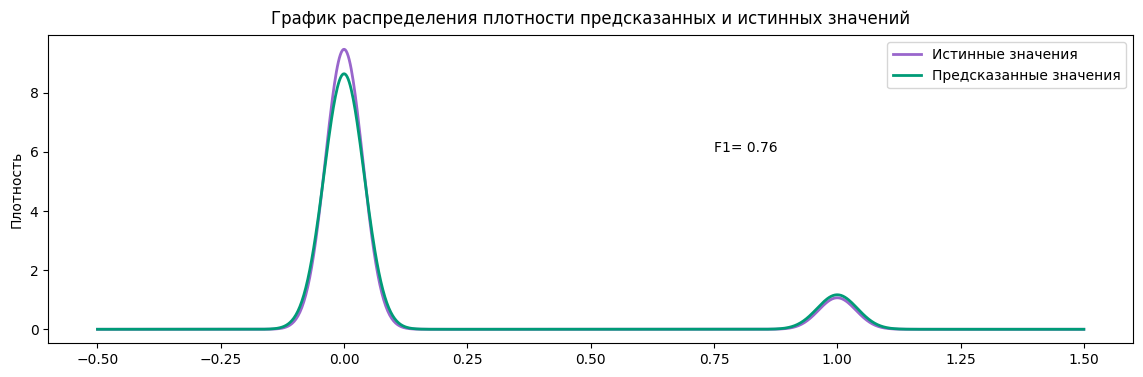

In [41]:
chart(target_valid, predict_linear_valid, linear_valid_f1)

### Random Forest

In [42]:
pipe_rf = Pipeline([('vect', CountVectorizer(stop_words=list(stopwords), analyzer='word', min_df=100)),
                   ('tfidf', TfidfTransformer()),
                   ('model', RandomForestClassifier(random_state=42))])

params_rf = {'model__n_estimators': [80, 100], 
          'model__max_depth': [10, 15, 20], 
          'model__min_samples_leaf': [2, 3, 4, 5],
          'model__min_samples_split': [2, 3, 4, 5]}

forest_gscv = GridSearchCV(estimator=pipe_rf, param_grid=params_rf, scoring='f1', cv=2)

start = time.time()

forest_gscv.fit(features_train['text'], target_train)

end = time.time()
print('Время подбора параметров c обучением: ', (end - start)/60, 'min')

forest_train_f1 = round(forest_gscv.best_score_, 2)

print('F1 случайного леса: ', forest_train_f1)
print('При параметрах', forest_gscv.best_params_)

Время подбора параметров c обучением:  32.1561080177625 min
F1 случайного леса:  0.32
При параметрах {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 80}


In [43]:
start = time.time()
predict_forest_valid = forest_gscv.predict(features_valid['text'])
forest_valid_f1 = f1_score(target_valid, predict_forest_valid)
end = time.time()
print('Время предсказания случайного леса равно: ', (end-start)/60, min)
print('F1 случайного леса на валидации: ', round(forest_valid_f1,2))

Время предсказания случайного леса равно:  0.03854258060455322 <built-in function min>
F1 случайного леса на валидации:  0.2


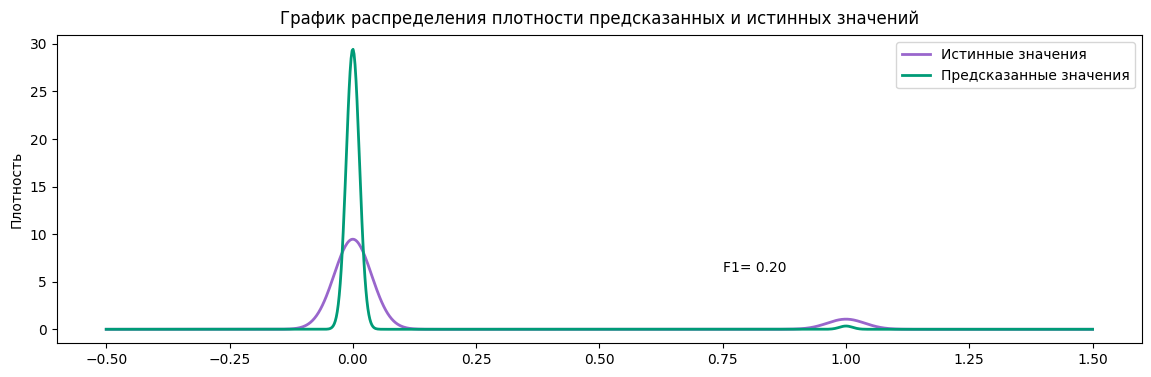

In [44]:
chart(target_valid, predict_forest_valid, forest_valid_f1)

### Decision Tree

In [45]:
pipe_dt = Pipeline([('vect',  CountVectorizer(stop_words=list(stopwords), analyzer='word', min_df=100)),
                    ('tfidf', TfidfTransformer()),
                    ('model', DecisionTreeClassifier(random_state=42))])

params_dt = {'model__max_depth': [1, 3],
          'model__class_weight': ['balanced']}

tree_gscv = GridSearchCV(estimator=pipe_dt, param_grid=params_dt, cv=5, scoring='f1')

start = time.time()
 
tree_gscv.fit(features_train['text'], target_train)

end = time.time()
print('Время подбора параметров c обучением: ', (end - start)/60, 'min')

tree_train_f1 = round(tree_gscv.best_score_, 2)

print('F1 дерева решений: ', tree_train_f1)
print('При параметрах', tree_gscv.best_params_)

Время подбора параметров c обучением:  1.167777375380198 min
F1 дерева решений:  0.37
При параметрах {'model__class_weight': 'balanced', 'model__max_depth': 3}


In [46]:
start = time.time()
predict_tree_valid = tree_gscv.predict(features_valid['text'])
tree_valid_f1 = f1_score(target_valid, predict_tree_valid)
end = time.time()
print('Время предсказания случайного леса равно: ', (end-start)/60, min)
print('F1 случайного леса на валидации: ', round(tree_valid_f1,2))

Время предсказания случайного леса равно:  0.031935938199361164 <built-in function min>
F1 случайного леса на валидации:  0.37


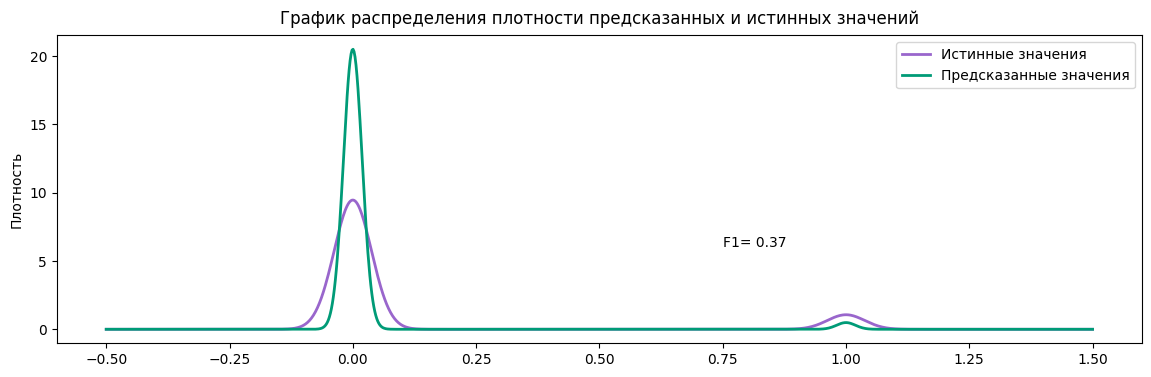

In [47]:
chart(target_valid, predict_tree_valid, tree_valid_f1)

### CatBoost c Pipeline без GridSearchCV

In [48]:
weight = round((len(target_train[target_train == 0]) / 
                          len(target_train[target_train == 1])), 3)
weight

8.767

In [49]:
pipe_cat = Pipeline([('vect',  CountVectorizer(stop_words=list(stopwords), analyzer='word', min_df=100)),
                    ('tfidf', TfidfTransformer()),
                    ('model', CatBoostClassifier(random_state=42, learning_rate=0.1, max_depth=2, 
                                                 verbose=300, eval_metric='TotalF1'))])
start = time.time()
model_cat = pipe_cat.fit(features_train['text'], target_train)

end = time.time()

print('Время подбора параметров c обучением: ', (end - start)/60, 'min')

0:	learn: 0.8955886	total: 273ms	remaining: 4m 32s
300:	learn: 0.9392791	total: 35.3s	remaining: 1m 22s
600:	learn: 0.9480291	total: 1m 11s	remaining: 47.2s
900:	learn: 0.9511946	total: 1m 46s	remaining: 11.7s
999:	learn: 0.9520146	total: 1m 57s	remaining: 0us
Время подбора параметров c обучением:  2.0745519757270814 min


In [50]:
predict_train_cat_pipe = model_cat.predict(features_train['text'])
cat_f1_tain_pipe = f1_score(target_train, predict_train_cat_pipe)

print('F1  CatBoost на train: ', round(cat_f1_tain_pipe,2))

F1  CatBoost на train:  0.74


In [51]:
start = time.time()
predict_cat_valid_pipe = model_cat.predict(features_valid['text'])
cat_valid_f1_pipe = f1_score(target_valid, predict_cat_valid_pipe)
end = time.time()
print('Время предсказания  CatBoost равно: ', (end-start)/60, min)
print('F1  CatBoost на валидации: ', round(cat_valid_f1_pipe,2))

Время предсказания  CatBoost равно:  0.034152738253275555 <built-in function min>
F1  CatBoost на валидации:  0.71


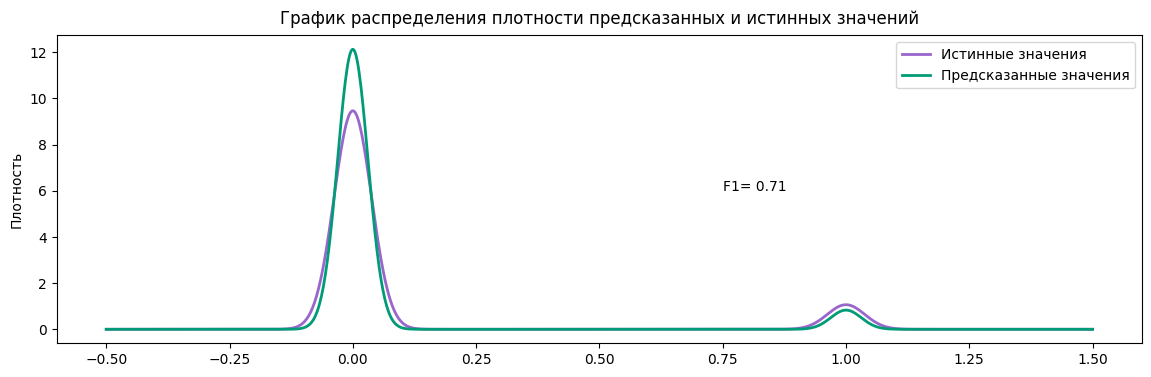

In [52]:
chart(target_valid, predict_cat_valid_pipe, cat_valid_f1_pipe)

### CatBoost c Pipeline и c GridSearchCV

ниже мы экспериментировали с подбором параметров, и оптимальными оказались model__learning_rate': 0.1, 'model__max_depth': 2, поэтому только они указаны в параметрах

In [53]:
pipe_cat_2 = Pipeline([('vect',  CountVectorizer(stop_words=list(stopwords), analyzer='word', min_df=100)),
                    ('tfidf', TfidfTransformer()),
                    ('model', CatBoostClassifier(random_state=42, verbose=300))])
                     
params_cat = {'model__learning_rate' : [0.2], 
          'model__max_depth': [6]}

cat_rscv =  GridSearchCV(estimator=pipe_cat_2, param_grid=params_cat, scoring='f1', cv=shuffle) 

start = time.time()

cat_rscv.fit(features_train['text'], target_train)

end = time.time()


print('Время подбора параметров c обучением: ', (end - start)/60, 'min')

0:	learn: 0.5122918	total: 364ms	remaining: 6m 3s
300:	learn: 0.1216628	total: 1m 42s	remaining: 3m 56s
600:	learn: 0.1006434	total: 3m 22s	remaining: 2m 14s
900:	learn: 0.0860146	total: 5m 2s	remaining: 33.2s
999:	learn: 0.0821161	total: 5m 35s	remaining: 0us
0:	learn: 0.5147034	total: 377ms	remaining: 6m 16s
300:	learn: 0.1214337	total: 1m 40s	remaining: 3m 53s
600:	learn: 0.0997954	total: 3m 21s	remaining: 2m 13s
900:	learn: 0.0852638	total: 5m 1s	remaining: 33.2s
999:	learn: 0.0815473	total: 5m 36s	remaining: 0us
0:	learn: 0.5103308	total: 370ms	remaining: 6m 9s
300:	learn: 0.1188222	total: 1m 42s	remaining: 3m 58s
600:	learn: 0.0971827	total: 3m 23s	remaining: 2m 15s
900:	learn: 0.0831843	total: 5m 3s	remaining: 33.4s
999:	learn: 0.0793553	total: 5m 37s	remaining: 0us
0:	learn: 0.5130619	total: 356ms	remaining: 5m 55s
300:	learn: 0.1210874	total: 1m 41s	remaining: 3m 56s
600:	learn: 0.0983916	total: 3m 22s	remaining: 2m 14s
900:	learn: 0.0843143	total: 5m 5s	remaining: 33.6s
999:	

In [54]:
cat_train_f1_pipe_grid = round(cat_rscv.best_score_, 2)

print('F1 CatBoost: ', cat_train_f1_pipe_grid)

print('При параметрах', cat_rscv.best_params_)

F1 CatBoost:  0.73
При параметрах {'model__learning_rate': 0.2, 'model__max_depth': 6}


In [55]:
start = time.time()
predict_cat_valid_pipe_grid = cat_rscv.predict(features_valid['text'])
cat_valid_f1_pipe_grid = f1_score(target_valid, predict_cat_valid_pipe_grid)
end = time.time()
print('Время предсказания  CatBoost равно: ', (end-start)/60, min)
print('F1  CatBoost на валидации: ', round(cat_valid_f1_pipe_grid,2))

Время предсказания  CatBoost равно:  0.036086225509643556 <built-in function min>
F1  CatBoost на валидации:  0.73


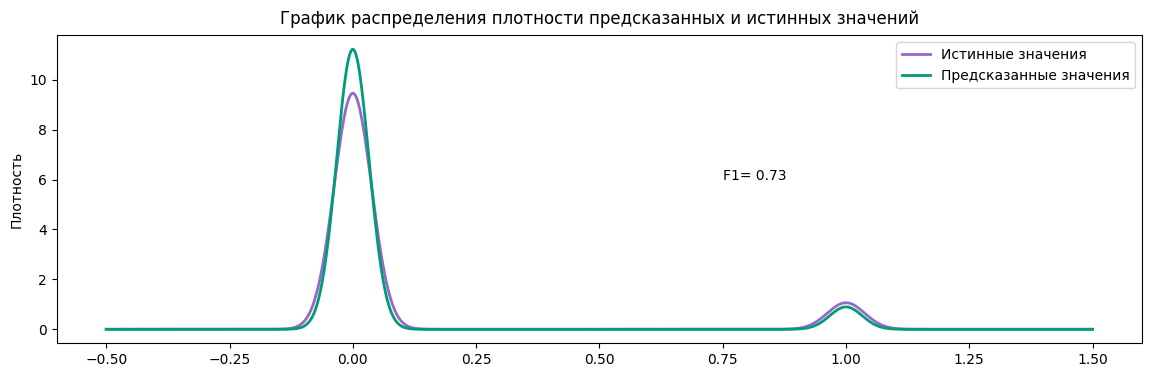

In [56]:
chart(target_valid, predict_cat_valid_pipe_grid, cat_valid_f1_pipe_grid)

#### Выведем не большую табличку с результатами предсказаний моделей

In [57]:
data = {'F1_train': [linear_train_f1, forest_train_f1, tree_train_f1, cat_f1_tain_pipe, cat_train_f1_pipe_grid],
        'F1_valid': [round(linear_valid_f1,2), forest_valid_f1, tree_valid_f1, cat_valid_f1_pipe, cat_valid_f1_pipe_grid]}

result = pd.DataFrame(data, index=['Logistic', 'Random_Forest', 'Decision Tree', 'Cat_Boost+Pipeline', 
                                   'CatBoost+Pipeline+GridSearchCV'])
result

,F1_train,F1_valid
Logistic,0.773270,0.760000
Random_Forest,0.320000,0.202398
Decision Tree,0.370000,0.366616
Cat_Boost+Pipeline,0.740828,0.706821
CatBoost+Pipeline+GridSearchCV,0.730000,0.733106


### Проверка выбранной модели

Наилучший показатель F1 меры показала модель логистической регрессии, поэтому проверим её на тестовых данных. Но стоит отметить, что модель CatBoost также имеет хорошие результаты, и скорее всего при подборе оптимальных параметров можно было бы использовать её, но так как она слишком долго обучается, мы не стали использовать  Pipeline вместе с  RandomizedSearchCV, то остановим свой выбор на логистической регресии.

In [58]:
start = time.time()
predict_linear_test = linear_gscv.predict(features_test['text'])
linear_test_f1 = f1_score(target_test, predict_linear_test)
end = time.time()
print('Время предсказания логистический регресии равно: ', (end-start)/60, 'min')
print('F1 логистической регрессии на тесте: ', round(linear_test_f1,2))

Время предсказания логистический регресии равно:  0.038653119405110674 min
F1 логистической регрессии на тесте:  0.76


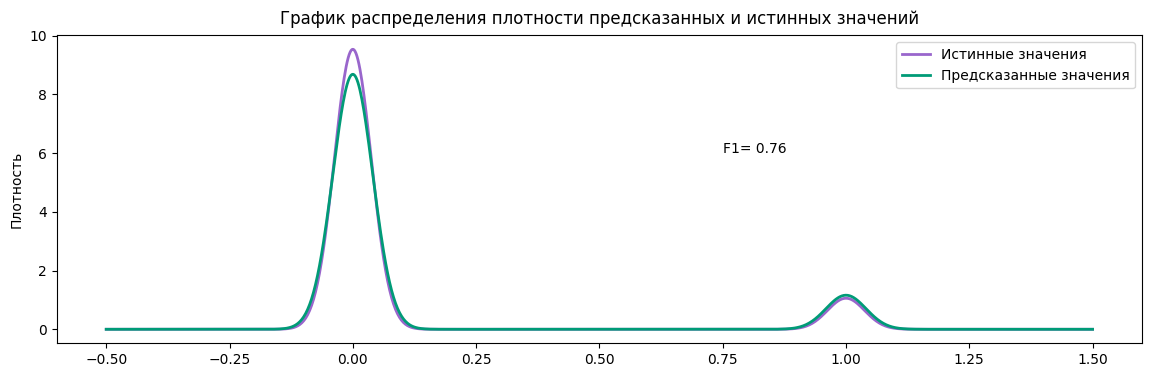

In [59]:
chart(target_test, predict_linear_test, linear_test_f1)

## Выводы

Модель LogisticRegression показала лучший результат на тестовых данных 0,76.

В вашем распоряжении был набор данных с разметкой о токсичности правок и целью проекта был инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. Нам надо было построить модель со значением метрики качества F1 не меньше 0.75. 

Предоставленные комментарии нам пришлось очистить от знаков пунктуации, провели лемматизацию, сбалансировали выбороки методами upsample и downsamle, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания предсказаний.

В работе были использованы логистическая модель, случайный лес и CatBoost, по итогам обучения которых наилучший показатель метрики F1 была достигнута на модели логистической регрессии.

Таким образом для магазина "ВИКИШОП" мы рекомендуем использовать в своей работе модель логистической регрессии.